## Cardio Gradient Boosting and Random Forests

In [1]:
# seed value for random number generators to obtain reproducible results
RANDOM_SEED = 1

# although we standardize X and y variables on input,
# we will fit the intercept term in the models
# Expect fitted values to be close to zero
SET_FIT_INTERCEPT = True

# import base packages into the namespace for this program
import numpy as np
import pandas as pd

# modeling routines from Scikit Learn packages
import sklearn.linear_model 
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score  
from math import sqrt  # for root mean-squared error calculation
import matplotlib
import matplotlib.pyplot as plt  # static plotting
import seaborn as sns  # pretty plotting, including heat map
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler #scale data

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
# specify the k-fold cross-validation design
from sklearn.model_selection import KFold

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.preprocessing import binarize
from sklearn.metrics import precision_recall_curve

## Defined functions

In [2]:
# define a function to return model metrics for evaluation

def model_metrics(y_known, y_pred):
    y_test = y_known
    y_pred_class = y_pred
    confusion = metrics.confusion_matrix(y_test, y_pred_class)
    TP = confusion[1, 1]
    TN = confusion[0, 0]
    FP = confusion[0, 1]
    FN = confusion[1, 0]
    accuracy = metrics.accuracy_score(y_test, y_pred_class)
    class_error = 1 - metrics.accuracy_score(y_test, y_pred_class)
    sensitivity = metrics.recall_score(y_test, y_pred_class)
    specificity = TN / (TN + FP)
    false_positive_rate = FP / float(TN + FP)
    precision = TP / float(TP + FP)
    f1_score = metrics.f1_score(y_test, y_pred_class)
#    F1 = 2*precision*sensitivity/(precision + sensitivity)
    print('The model metrics are:',
         '\naccuracy:', accuracy,
         '\nclassification error:', class_error,
         '\nsensitivity:', sensitivity,
         '\nspecificity:', specificity,
         '\nfalse positive rate:', false_positive_rate,
         '\nprecision:', precision,
          '\nF1 score:', f1_score,
#          '\nF1 by hand:', F1,
         '\nconfusion matrix:')
    return(confusion)


In [3]:
# define a function that accepts a threshold and 
# prints sensitivity and specificity

def evaluate_threshold(threshold):
    print('Sensitivity:', tpr[thresholds > threshold][-1])
    print('Specificity:', 1 - fpr[thresholds > threshold][-1])

In [4]:
# define a function that accepts the fpr and tpr values 
# from the roc_curve function and plot the ROC curve

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve for response')


In [5]:
# define a function that accepts the recall and precision values 
# from the precision_recall_curve function and plot the PR curve

def plot_pr_curve(recall, precision, label=None):
    plt.plot(recall, precision, linewidth=2, label=label)
#    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('PR curve for response')

## Import data set and prepare for analysis

### This uses the data prepared by Erin, but I don't know how to scale this

In [6]:
# initial work with the smaller data set
X_test = pd.read_csv('cardio_x_test.csv', sep = ',', encoding = 'unicode_escape')  
X_train = pd.read_csv('cardio_x_train.csv', sep = ',', encoding = 'unicode_escape')  
y_test = pd.read_csv('cardio_y_test.csv', sep = ',', encoding = 'unicode_escape')  
y_train = pd.read_csv('cardio_y_train.csv', sep = ',', encoding = 'unicode_escape')
# examine the shape of original input data
print('The shape of the X test set is: ', X_test.shape)
print('The shape of the X train set is: ',X_train.shape)
print('The shape of the Y test set is: ',y_test.shape)
print('The shape of the Y train set is: ',y_train.shape)

The shape of the X test set is:  (13750, 24)
The shape of the X train set is:  (54997, 24)
The shape of the Y test set is:  (13750, 2)
The shape of the Y train set is:  (54997, 2)


In [7]:
#drop unnecessary columns for model
X_train = X_train.drop(['Unnamed: 0', 'id', 'age_days', 'LATITUDE',
                 'LONGITUDE','ZIP','FACILITY_NAME','ADDRESS',
                 'CITY','STATE','DESCRIPTION','FACILITY_TYPE' ], axis=1)
X_test = X_test.drop(['Unnamed: 0', 'id', 'age_days', 'LATITUDE',
                 'LONGITUDE','ZIP','FACILITY_NAME','ADDRESS',
                 'CITY','STATE','DESCRIPTION','FACILITY_TYPE' ], axis=1)
y_train = y_train.drop(['Unnamed: 0'], axis=1)
y_test = y_test.drop(['Unnamed: 0'], axis=1)    


In [8]:
#rename the column in the target train and test sets
y_train = y_train.rename(columns={"x": "cardio"})
y_test = y_test.rename(columns={"x": "cardio"})

In [9]:
#total number of NaN values in each column
print('The total number of NaN values in the X test set is:\n', X_test.isnull().sum())
print('The total number of NaN values in the X train set is:\n',X_train.isnull().sum())
print('The total number of NaN values in the Y test set is:\n',y_test.isnull().sum())
print('The total number of NaN values in the Y train set is:\n',y_train.isnull().sum())


The total number of NaN values in the X test set is:
 age_years      0
gender         0
height_cm      0
weight_kg      0
BMI            0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alcohol        0
active         0
dtype: int64
The total number of NaN values in the X train set is:
 age_years      0
gender         0
height_cm      0
weight_kg      0
BMI            0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alcohol        0
active         0
dtype: int64
The total number of NaN values in the Y test set is:
 cardio    0
dtype: int64
The total number of NaN values in the Y train set is:
 cardio    0
dtype: int64


In [10]:
# mapping function to convert text female/male to integer 1/2
convert_to_binary = {'female' : 1, 'male' : 2}

# define binary variable for gender
X_train['gender'] = X_train['gender'].map(convert_to_binary)
X_test['gender'] = X_test['gender'].map(convert_to_binary)

In [11]:
X_train.head()

,age_years,gender,height_cm,weight_kg,BMI,ap_hi,ap_lo,cholesterol,gluc,smoke,alcohol,active
0,62,1,160,101.0,39.453125,120,70,1,1,0,0,1
1,41,2,172,78.0,26.365603,140,80,1,1,0,0,1
2,57,1,168,80.0,28.344671,140,90,1,1,0,0,1
3,52,1,161,75.0,28.934069,110,80,2,3,0,0,1
4,39,1,169,64.0,22.408179,100,70,1,1,0,0,1


In [12]:
y_train.head()

,cardio
0,1
1,0
2,1
3,0
4,0


## Pipeline

### Use pipeline to evaluate Random Forest and Gradient Boosting Classifiers

Basic pipeline.
I'm going to use GridSearchCV separately.

In [13]:
#For Gradient Boosting Regressor:
#The learning_rate hyperparameter scales the contribution of each tree. 
#If you set it to a low value, such as 0.1, you will need more trees in 
#the ensemble to fit the training set, but the predictions will usually 
#generalize better. This is a regularization technique called shrinkage. 

# create a list of classifiers to be used in the pipeline
en_classifiers = [RandomForestClassifier(n_estimators=100, max_leaf_nodes=16, n_jobs=-1, bootstrap=True, random_state=RANDOM_SEED),
                  GradientBoostingClassifier(n_estimators=100, max_depth=2, learning_rate=1.0, random_state=RANDOM_SEED)]


In [14]:
#loop through each of the classifiers in the list
# use pipeline to instantiate the model and fit to training data
# score each model on training and test data sets
# use cross validation score to calculate RMSE

for classifier in en_classifiers:
    pipe = Pipeline(steps=[('classifier', classifier)])
    pipe.fit(X_train, y_train.values.ravel())
    pipe_scores = cross_val_score(pipe, X_train, y_train.values.ravel(),
                         scoring="neg_mean_squared_error", cv=10)
    pipe_rmse_scores = np.sqrt(-pipe_scores)
    print('\n----------------------------')
    print('\nClassifier evaluation for:')
    print(classifier)
    print('Model training score: {:.3f}'.format(pipe.score(X_train, y_train)))
    print('Model test score: {:.3f}'.format(pipe.score(X_test, y_test)))
    print('RMSE mean: {:.3f}'.format(pipe_rmse_scores.mean()))
    print('RMSE standard deviation: {:.3f}'.format(pipe_rmse_scores.std()))


----------------------------

Classifier evaluation for:
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=16, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)
Model training score: 0.727
Model test score: 0.725
RMSE mean: 0.523
RMSE standard deviation: 0.004

----------------------------

Classifier evaluation for:
GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=1.0, loss='deviance', max_depth=2,
                           max_features=None, max_leaf_nodes=None,
                      

## Grid Search

### Grid Search for Gradient Boosting Classifier

This is using train sets instead of the unsplit data

In [15]:
from sklearn.model_selection import GridSearchCV

gbc_param_grid = [
    {'max_leaf_nodes': [2,6,10,14,16,20], 
     'max_features': ['auto', 'log2']}]


gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, random_state=RANDOM_SEED)

gbc_grid_search = GridSearchCV(gbc, gbc_param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

gbc_grid_search.fit(X_train, y_train.values.ravel())

GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=1.0,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
         

In [16]:
print('\n----------------------------')
print('The parameters choosen by Grid Search for Gradient Boosting Classifier:\n ')
gbc_grid_search.best_params_


----------------------------
The parameters choosen by Grid Search for Gradient Boosting Classifier:
 


{'max_features': 'auto', 'max_leaf_nodes': 2}

In [17]:
#print the mean RMSE for each model evaluated
#the model with the lowest mean RMSE is best

gbc_cvres = gbc_grid_search.cv_results_

for mean_score, params in zip(gbc_cvres["mean_test_score"], gbc_cvres["params"]):
    print('Mean RMSE:', np.sqrt(-mean_score), params)

Mean RMSE: 0.5182278094477557 {'max_features': 'auto', 'max_leaf_nodes': 2}
Mean RMSE: 0.5208875464543294 {'max_features': 'auto', 'max_leaf_nodes': 6}
Mean RMSE: 0.5239676852969414 {'max_features': 'auto', 'max_leaf_nodes': 10}
Mean RMSE: 0.5239676852969414 {'max_features': 'auto', 'max_leaf_nodes': 14}
Mean RMSE: 0.5239676852969414 {'max_features': 'auto', 'max_leaf_nodes': 16}
Mean RMSE: 0.5239676852969414 {'max_features': 'auto', 'max_leaf_nodes': 20}
Mean RMSE: 0.518368146411356 {'max_features': 'log2', 'max_leaf_nodes': 2}
Mean RMSE: 0.5199092495660604 {'max_features': 'log2', 'max_leaf_nodes': 6}
Mean RMSE: 0.5227343838535806 {'max_features': 'log2', 'max_leaf_nodes': 10}
Mean RMSE: 0.5227343838535806 {'max_features': 'log2', 'max_leaf_nodes': 14}
Mean RMSE: 0.5227343838535806 {'max_features': 'log2', 'max_leaf_nodes': 16}
Mean RMSE: 0.5227343838535806 {'max_features': 'log2', 'max_leaf_nodes': 20}


In [18]:
#perform grid search again to find optimal max_depth, learning rate and n_estimators
#this takes a while
gbc_param_grid = [
    {'learning_rate': [0.01, 0.1, 1.0, 10], 
     'n_estimators': [50,100,200],
     'max_depth': [2,6,8,10,12]}]


gbc = GradientBoostingClassifier(max_leaf_nodes=2, max_features='auto', random_state=RANDOM_SEED)

gbc_grid_search = GridSearchCV(gbc, gbc_param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

gbc_grid_search.fit(X_train, y_train.values.ravel())

GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features='auto',
                                                  max_leaf_nodes=2,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_ch...ne,
              

In [19]:
print('\n----------------------------')
print('The parameters choosen by Grid Search for Gradient Boosting Classifier:\n ')
gbc_grid_search.best_params_


----------------------------
The parameters choosen by Grid Search for Gradient Boosting Classifier:
 


{'learning_rate': 1.0, 'max_depth': 2, 'n_estimators': 100}

In [20]:
gbc_cvres = gbc_grid_search.cv_results_

for mean_score, params in zip(gbc_cvres["mean_test_score"], gbc_cvres["params"]):
    print('Mean RMSE:', np.sqrt(-mean_score), params)

Mean RMSE: 0.5363150869599007 {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 50}
Mean RMSE: 0.5363150869599007 {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 100}
Mean RMSE: 0.5363150869599007 {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 200}
Mean RMSE: 0.5363150869599007 {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 50}
Mean RMSE: 0.5363150869599007 {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}
Mean RMSE: 0.5363150869599007 {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}
Mean RMSE: 0.5363150869599007 {'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 50}
Mean RMSE: 0.5363150869599007 {'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 100}
Mean RMSE: 0.5363150869599007 {'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 200}
Mean RMSE: 0.5363150869599007 {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 50}
Mean RMSE: 0.5363150869599007 {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 100}
M

### Fitting the best GB model based on GridSearchCV results

In [21]:
#use the information from GridSearch to fit the best GB model
# Instantiate model
gbc_best = GradientBoostingClassifier(n_estimators=100, max_depth=2, 
                                        learning_rate=1.0, max_features='auto', 
                                        max_leaf_nodes=2, random_state=RANDOM_SEED)

# Fit the model
gbc = gbc_best.fit(X_train, y_train.values.ravel())

print('\n----------------------------')
print('Gradient Boosting\n')
print(gbc)
#print('intercept:', lr_intercept)
#print('coefficients:', lr_coef)


----------------------------
Gradient Boosting

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=1.0, loss='deviance', max_depth=2,
                           max_features='auto', max_leaf_nodes=2,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=1, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


In [22]:
# make predictions for the testing set
y_predictions_gbc = gbc.predict(X_test)

In [23]:
# make predicted probabilities for the predictions
y_predict_prob_gbc = gbc.predict_proba(X_test)

In [24]:
# the first argument is true values, 
# the second argument is predicted values
# this produces a 2x2 numpy array (matrix)

confusion_gbc = metrics.confusion_matrix(y_test, y_predictions_gbc)
print(confusion_gbc)

[[5587 1380]
 [2314 4469]]


In [25]:
# precision, recall, F1 score, and count of response variable
# of gradient boosting classifier

print(classification_report(y_test, y_predictions_gbc))

              precision    recall  f1-score   support

           0       0.71      0.80      0.75      6967
           1       0.76      0.66      0.71      6783

    accuracy                           0.73     13750
   macro avg       0.74      0.73      0.73     13750
weighted avg       0.74      0.73      0.73     13750



In [26]:
# evaluate gradient boosting classifer


model_metrics(y_test, y_predictions_gbc)

#y_predictions_gbr is the predicted response value

The model metrics are: 
accuracy: 0.7313454545454545 
classification error: 0.2686545454545455 
sensitivity: 0.6588530148901666 
specificity: 0.8019233529496196 
false positive rate: 0.19807664705038036 
precision: 0.764062232860318 
F1 score: 0.7075680810639645 
confusion matrix:


array([[5587, 1380],
       [2314, 4469]])

Confusion matrix, without normalization
[[5587 1380]
 [2314 4469]]
Normalized confusion matrix
[[0.8019 0.1981]
 [0.3411 0.6589]]


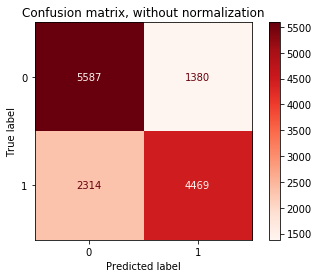

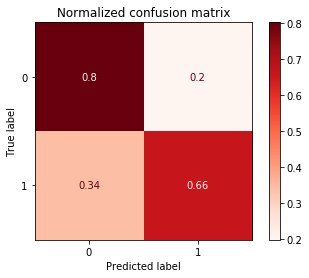

In [27]:
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
from sklearn.metrics import plot_confusion_matrix

target_names=['0', '1']
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None, "0.0f"),
                  ("Normalized confusion matrix", 'true', None)]
for title, normalize, values_format in titles_options:
    disp = plot_confusion_matrix(gbc_best, X_test, y_test,
                                 display_labels=target_names,
                                 cmap=plt.cm.Reds,
                                 normalize=normalize,
                                 values_format=values_format,
                                )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)
    #plt.grid(None)
    plt.savefig('GradientBoosting {0}.png'.format(title))

    
plt.show()

In [28]:
print("Training set score: {:.2f}".format(gbc.score(X_train, y_train)))
print("Test set score: {:.2f}".format(gbc.score(X_test, y_test)))

Training set score: 0.73
Test set score: 0.73


## ROC Curve

In [29]:
# make predicted probabilities for the predictions
# gradient boosting classifier
# store the predicted probabilities for class 1 of response

y_pred_prob_gbc = gbc.predict_proba(X_test)[:, 1]

In [30]:
# the first argument is true values, 
# the second argument is predicted probabilities

# pass y_test and y_pred_prob
# do not use y_pred_class, because it will 
# give incorrect results without generating an error
# roc_curve returns 3 objects fpr, tpr, thresholds
# fpr: false positive rate
# tpr: true positive rate

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_gbc)

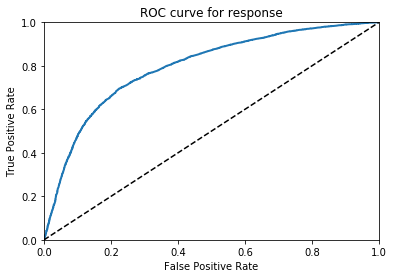

In [31]:
# plot the ROC curve for the gradient boosting classifer
    
plot_roc_curve(fpr, tpr)
plt.savefig('ROC_GBC_plot.pdf')
plt.show()

In [32]:
# evaluate the GBC
# sensitivity and specificity when the threshold is set to 0.5

print('When the threshold is set to 0.5')
evaluate_threshold(0.5)

When the threshold is set to 0.5
Sensitivity: 0.6588530148901666
Specificity: 0.8022104205540405


In [33]:
# AUC is the percentage of the ROC plot that is underneath the curve
# first argument is true values, second argument is predicted probabilities
# AUC for logistic regression, C = 100

roc_auc_y_gbc_class1 = metrics.roc_auc_score(y_test, y_pred_prob_gbc)

print('\nThe AUC is:', roc_auc_y_gbc_class1)


The AUC is: 0.7955369875054492


### Grid Search for Random Forest Classifier

In [34]:
rf_param_grid = [
    {'max_features': [1,2,3,4,5,6,7,8,9,10,'sqrt', 'log2', 'auto']}]


rf = RandomForestClassifier(max_depth=2, n_jobs=-1, bootstrap=True, random_state=RANDOM_SEED)

rf_grid_search = GridSearchCV(rf, rf_param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

rf_grid_search.fit(X_train, y_train.values.ravel())

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=2,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=-1,
                                              oob_score=False, random_state=1,
                                        

In [35]:
print('\n----------------------------')
print('The parameters choosen by Grid Search for Random Forest Classifier:\n ')
rf_grid_search.best_params_


----------------------------
The parameters choosen by Grid Search for Random Forest Classifier:
 


{'max_features': 3}

In [36]:
#print the mean RMSE for each model evaluated
#the model with the lowest mean RMSE is best

rf_cvres = rf_grid_search.cv_results_

for mean_score, params in zip(rf_cvres["mean_test_score"], rf_cvres["params"]):
    print('Mean RMSE:', np.sqrt(-mean_score), params)

Mean RMSE: 0.5348722360101746 {'max_features': 1}
Mean RMSE: 0.5336129588385188 {'max_features': 2}
Mean RMSE: 0.5273920975118335 {'max_features': 3}
Mean RMSE: 0.5359080605429443 {'max_features': 4}
Mean RMSE: 0.5337833139071397 {'max_features': 5}
Mean RMSE: 0.5301944954856207 {'max_features': 6}
Mean RMSE: 0.535568683405132 {'max_features': 7}
Mean RMSE: 0.5356196085450761 {'max_features': 8}
Mean RMSE: 0.5356026340364243 {'max_features': 9}
Mean RMSE: 0.5357893240539858 {'max_features': 10}
Mean RMSE: 0.5273920975118335 {'max_features': 'sqrt'}
Mean RMSE: 0.5273920975118335 {'max_features': 'log2'}
Mean RMSE: 0.5273920975118335 {'max_features': 'auto'}


In [37]:
#perform grid search again to find optimal n_estimators
rf_param_grid = [
    {'n_estimators': [50,100,200,300]}]


rf = RandomForestClassifier(max_depth=2, max_features=3, n_jobs=-1, bootstrap=True, random_state=RANDOM_SEED)

rf_grid_search = GridSearchCV(rf, rf_param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

rf_grid_search.fit(X_train, y_train.values.ravel())

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=2,
                                              max_features=3,
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=-1,
                                              oob_score=False, random_state=1,
                                             

In [38]:
print('\n----------------------------')
print('The parameters choosen by Grid Search for Random Forest Classifier:\n ')
rf_grid_search.best_params_


----------------------------
The parameters choosen by Grid Search for Random Forest Classifier:
 


{'n_estimators': 100}

In [39]:
#print the mean RMSE for each model evaluated
#the model with the lowest mean RMSE is best

rf_cvres = rf_grid_search.cv_results_

for mean_score, params in zip(rf_cvres["mean_test_score"], rf_cvres["params"]):
    print('Mean RMSE:', np.sqrt(-mean_score), params)

Mean RMSE: 0.5278056551836593 {'n_estimators': 50}
Mean RMSE: 0.5273920975118335 {'n_estimators': 100}
Mean RMSE: 0.5296798547215076 {'n_estimators': 200}
Mean RMSE: 0.5302973855252754 {'n_estimators': 300}


In [40]:
#use the information from GridSearch to fit the best RF model
# Instantiate model
rf_best = RandomForestClassifier(n_estimators=100, max_depth=2, max_features=3, 
                                 n_jobs=-1, bootstrap=True, random_state=RANDOM_SEED)

# Fit the model
rf = rf_best.fit(X_train, y_train.values.ravel())

print('\n----------------------------')
print('Random Forest\n')
print(rf)
#print('intercept:', lr_intercept)
#print('coefficients:', lr_coef)


----------------------------
Random Forest

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=2, max_features=3,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)


In [41]:
# make predictions for the testing set
y_predictions_rf = rf.predict(X_test)

In [42]:
# make predicted probabilities for the predictions
y_predict_prob_rf = rf.predict_proba(X_test)

In [43]:
# the first argument is true values, 
# the second argument is predicted values
# this produces a 2x2 numpy array (matrix)

confusion_rf = metrics.confusion_matrix(y_test, y_predictions_rf)
print(confusion_rf)

[[5547 1420]
 [2405 4378]]


In [44]:
# precision, recall, F1 score, and count of response variable
# of Random Forest classifier

print(classification_report(y_test, y_predictions_rf))

              precision    recall  f1-score   support

           0       0.70      0.80      0.74      6967
           1       0.76      0.65      0.70      6783

    accuracy                           0.72     13750
   macro avg       0.73      0.72      0.72     13750
weighted avg       0.73      0.72      0.72     13750



In [45]:
# evaluate random forest classifer


model_metrics(y_test, y_predictions_rf)

#y_predictions_gbr is the predicted response value

The model metrics are: 
accuracy: 0.7218181818181818 
classification error: 0.2781818181818182 
sensitivity: 0.645437122217308 
specificity: 0.7961820008612028 
false positive rate: 0.2038179991387972 
precision: 0.7550879613659883 
F1 score: 0.6959701136634608 
confusion matrix:


array([[5547, 1420],
       [2405, 4378]])

Confusion matrix, without normalization
[[5547 1420]
 [2405 4378]]
Normalized confusion matrix
[[0.7962 0.2038]
 [0.3546 0.6454]]


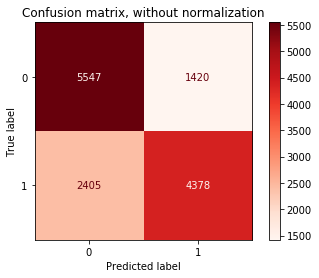

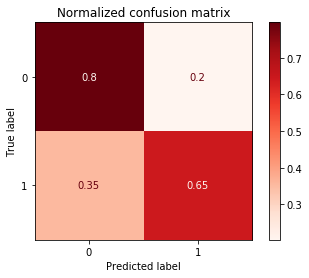

In [46]:
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
from sklearn.metrics import plot_confusion_matrix

target_names=['0', '1']
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None, "0.0f"),
                  ("Normalized confusion matrix", 'true', None)]
for title, normalize, values_format in titles_options:
    disp = plot_confusion_matrix(rf_best, X_test, y_test,
                                 display_labels=target_names,
                                 cmap=plt.cm.Reds,
                                 normalize=normalize,
                                 values_format=values_format,
                                )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)
    #plt.grid(None)
    plt.savefig('RandomForest {0}.png'.format(title))

    
plt.show()

In [47]:
print("Training set score: {:.2f}".format(rf.score(X_train, y_train)))
print("Test set score: {:.2f}".format(rf.score(X_test, y_test)))

Training set score: 0.72
Test set score: 0.72


## ROC Curve

In [48]:
# make predicted probabilities for the predictions
# random forest classifier
# store the predicted probabilities for class 1 of response

y_pred_prob_rf = rf.predict_proba(X_test)[:, 1]

In [49]:
# the first argument is true values, 
# the second argument is predicted probabilities

# pass y_test and y_pred_prob
# do not use y_pred_class, because it will 
# give incorrect results without generating an error
# roc_curve returns 3 objects fpr, tpr, thresholds
# fpr: false positive rate
# tpr: true positive rate

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_rf)

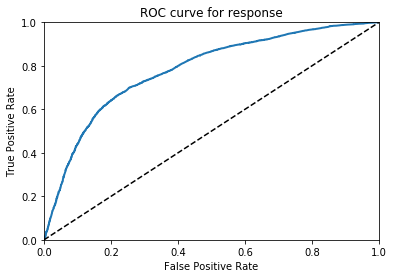

In [50]:
# plot the ROC curve for the random forest classifer
    
plot_roc_curve(fpr, tpr)
plt.savefig('ROC_RF_plot.pdf')
plt.show()

In [51]:
# evaluate the RFC
# sensitivity and specificity when the threshold is set to 0.5

print('When the threshold is set to 0.5')
evaluate_threshold(0.5)

When the threshold is set to 0.5
Sensitivity: 0.645437122217308
Specificity: 0.7963255346634133


In [52]:
# AUC is the percentage of the ROC plot that is underneath the curve
# first argument is true values, second argument is predicted probabilities
# AUC for logistic regression, C = 100

roc_auc_y_rf_class1 = metrics.roc_auc_score(y_test, y_pred_prob_rf)

print('\nThe AUC is:', roc_auc_y_rf_class1)


The AUC is: 0.7816550384818928
